In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import apriori
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

In [75]:
df = pd.read_csv('supermarket.csv')

In [76]:
df.head(3)

,SHOP_WEEK,SHOP_DATE,SHOP_WEEKDAY,SHOP_HOUR,QUANTITY,SPEND,PROD_CODE,PROD_CODE_10,PROD_CODE_20,PROD_CODE_30,...,CUST_PRICE_SENSITIVITY,CUST_LIFESTAGE,BASKET_ID,BASKET_SIZE,BASKET_PRICE_SENSITIVITY,BASKET_TYPE,BASKET_DOMINANT_MISSION,STORE_CODE,STORE_FORMAT,STORE_REGION
0,200734,20071019,6,8,1,9.50,PRD0901335,CL00058,DEP00016,G00006,...,XX,OT,994108000679877,M,MM,Small Shop,Fresh,STORE00001,LS,E02
1,200805,20080328,6,21,1,1.49,PRD0901120,CL00162,DEP00055,G00016,...,XX,NaN,994110300629787,S,MM,Small Shop,Fresh,STORE00001,LS,E02
2,200716,20070612,3,9,1,0.86,PRD0900963,CL00248,DEP00089,G00030,...,NaN,NaN,994106200026009,S,MM,Small Shop,Grocery,STORE00001,LS,E02


In [77]:
# df['SHOP_DATE'] = df['SHOP_DATE'].astype(str)

# df['SHOP_DATE'] = df['SHOP_DATE'].astype(str)
# df['shop_year'] = df['SHOP_DATE'].str[:4].astype(int)
# df['shop_month'] = df['SHOP_DATE'].str[4:6].astype(int)
# df['shop_day'] = df['SHOP_DATE'].str[4:6].astype(int)
# df['SHOP_DATE'] = df['SHOP_DATE'].astype(int)
# df.head()

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 578082 entries, 0 to 578081
Data columns (total 22 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SHOP_WEEK                 578082 non-null  int64  
 1   SHOP_DATE                 578082 non-null  int64  
 2   SHOP_WEEKDAY              578082 non-null  int64  
 3   SHOP_HOUR                 578082 non-null  int64  
 4   QUANTITY                  578082 non-null  int64  
 5   SPEND                     578082 non-null  float64
 6   PROD_CODE                 578082 non-null  object 
 7   PROD_CODE_10              578082 non-null  object 
 8   PROD_CODE_20              578082 non-null  object 
 9   PROD_CODE_30              578082 non-null  object 
 10  PROD_CODE_40              578082 non-null  object 
 11  CUST_CODE                 492494 non-null  object 
 12  CUST_PRICE_SENSITIVITY    492494 non-null  object 
 13  CUST_LIFESTAGE            433142 non-null  o

In [79]:
maxdate = df['SHOP_DATE'].max()
print(maxdate)

20080706


In [80]:
start_date = 20070706 # 1 year before max date
df.dropna(subset=['CUST_CODE'], inplace=True)
df = df.loc[df['SHOP_DATE']>=start_date]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 225903 entries, 0 to 578081
Data columns (total 22 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SHOP_WEEK                 225903 non-null  int64  
 1   SHOP_DATE                 225903 non-null  int64  
 2   SHOP_WEEKDAY              225903 non-null  int64  
 3   SHOP_HOUR                 225903 non-null  int64  
 4   QUANTITY                  225903 non-null  int64  
 5   SPEND                     225903 non-null  float64
 6   PROD_CODE                 225903 non-null  object 
 7   PROD_CODE_10              225903 non-null  object 
 8   PROD_CODE_20              225903 non-null  object 
 9   PROD_CODE_30              225903 non-null  object 
 10  PROD_CODE_40              225903 non-null  object 
 11  CUST_CODE                 225903 non-null  object 
 12  CUST_PRICE_SENSITIVITY    225903 non-null  object 
 13  CUST_LIFESTAGE            198560 non-null  o

In [81]:
df_bkt_unique = df.drop_duplicates(subset=['CUST_CODE', 'BASKET_ID'])
df_bkt_unique.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30189 entries, 0 to 578057
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   SHOP_WEEK                 30189 non-null  int64  
 1   SHOP_DATE                 30189 non-null  int64  
 2   SHOP_WEEKDAY              30189 non-null  int64  
 3   SHOP_HOUR                 30189 non-null  int64  
 4   QUANTITY                  30189 non-null  int64  
 5   SPEND                     30189 non-null  float64
 6   PROD_CODE                 30189 non-null  object 
 7   PROD_CODE_10              30189 non-null  object 
 8   PROD_CODE_20              30189 non-null  object 
 9   PROD_CODE_30              30189 non-null  object 
 10  PROD_CODE_40              30189 non-null  object 
 11  CUST_CODE                 30189 non-null  object 
 12  CUST_PRICE_SENSITIVITY    30189 non-null  object 
 13  CUST_LIFESTAGE            26390 non-null  object 
 14  BASKE

In [82]:
def create_proportion(df, col):
    # Group by ID and count unique strings
    grouped = df.groupby('CUST_CODE')[col].value_counts().unstack(fill_value=0)

    # Calculate total string counts for each ID
    grouped['Total'] = grouped.sum(axis=1)

    # Calculate proportion columns
    unique_strings = grouped.columns[:-1]
    proportion_columns = [f'{string}_{col}' for string in unique_strings]
    grouped[proportion_columns] = grouped[unique_strings].div(grouped['Total'], axis=0)

    # Reset the index if desired
    grouped.reset_index(inplace=True)

    # Select only the 'ID' column and proportion columns
    result = grouped[['CUST_CODE'] + proportion_columns]

    return result

In [83]:
df_bkt_type = create_proportion(df_bkt_unique, 'BASKET_TYPE')
df_bkt_type.head(3)

BASKET_TYPE,CUST_CODE,Full Shop_BASKET_TYPE,Small Shop_BASKET_TYPE,Top Up_BASKET_TYPE,XX_BASKET_TYPE
0,CUST0000000689,0.437500,0.312500,0.250000,0.0
1,CUST0000001163,0.000000,1.000000,0.000000,0.0
2,CUST0000001194,0.418182,0.145455,0.436364,0.0


In [84]:
df_bkt_dom = create_proportion(df_bkt_unique, 'BASKET_DOMINANT_MISSION')
df_bkt_dom.head(3)

BASKET_DOMINANT_MISSION,CUST_CODE,Fresh_BASKET_DOMINANT_MISSION,Grocery_BASKET_DOMINANT_MISSION,Mixed_BASKET_DOMINANT_MISSION,Nonfood_BASKET_DOMINANT_MISSION,XX_BASKET_DOMINANT_MISSION
0,CUST0000000689,0.312500,0.187500,0.437500,0.062500,0.0
1,CUST0000001163,1.000000,0.000000,0.000000,0.000000,0.0
2,CUST0000001194,0.654545,0.109091,0.218182,0.018182,0.0


In [85]:
df_bkt_sen = create_proportion(df_bkt_unique, 'BASKET_PRICE_SENSITIVITY')
df_bkt_sen.head(3)

BASKET_PRICE_SENSITIVITY,CUST_CODE,LA_BASKET_PRICE_SENSITIVITY,MM_BASKET_PRICE_SENSITIVITY,UM_BASKET_PRICE_SENSITIVITY,XX_BASKET_PRICE_SENSITIVITY
0,CUST0000000689,0.375000,0.625000,0.000000,0.0
1,CUST0000001163,0.000000,1.000000,0.000000,0.0
2,CUST0000001194,0.018182,0.654545,0.327273,0.0


In [86]:
df_bkt_size = df.groupby(['CUST_CODE', 'BASKET_ID'])[['SPEND']].sum().groupby('CUST_CODE').agg(bkt_size=('SPEND', 'mean')).reset_index()
df_bkt_size.head(3)

,CUST_CODE,bkt_size
0,CUST0000000689,20.535625
1,CUST0000001163,0.520000
2,CUST0000001194,29.294909


In [87]:
df_idgroup = df.groupby('CUST_CODE')

df_total_spend = df_idgroup.agg(total_spend=('SPEND', 'sum')).reset_index()
df_total_spend.head(3)

,CUST_CODE,total_spend
0,CUST0000000689,328.57
1,CUST0000001163,0.52
2,CUST0000001194,1611.22


In [88]:
df_bkt_count = df_idgroup.agg(basket_count=('BASKET_ID', 'nunique')).reset_index()
df_bkt_count.head(3)

,CUST_CODE,basket_count
0,CUST0000000689,16
1,CUST0000001163,1
2,CUST0000001194,55


In [89]:
maxdate = df['SHOP_DATE'].max()
df_recency = df_idgroup.agg(recency=('SHOP_DATE', 'max')).reset_index()
df_recency['recency'] = maxdate - df_recency['recency']
df_recency.head(3)

,CUST_CODE,recency
0,CUST0000000689,83
1,CUST0000001163,84
2,CUST0000001194,86


In [90]:
df_scv = pd.merge(df_total_spend, df_bkt_count, on='CUST_CODE')
df_scv = pd.merge(df_scv, df_bkt_type, on='CUST_CODE')
df_scv = pd.merge(df_scv, df_bkt_dom, on='CUST_CODE')
df_scv = pd.merge(df_scv, df_bkt_sen, on='CUST_CODE')
df_scv = pd.merge(df_scv, df_recency, on='CUST_CODE')
df_scv = pd.merge(df_scv, df_bkt_size, on='CUST_CODE')

df_scv.head(3)

,CUST_CODE,total_spend,basket_count,Full Shop_BASKET_TYPE,Small Shop_BASKET_TYPE,Top Up_BASKET_TYPE,XX_BASKET_TYPE,Fresh_BASKET_DOMINANT_MISSION,Grocery_BASKET_DOMINANT_MISSION,Mixed_BASKET_DOMINANT_MISSION,Nonfood_BASKET_DOMINANT_MISSION,XX_BASKET_DOMINANT_MISSION,LA_BASKET_PRICE_SENSITIVITY,MM_BASKET_PRICE_SENSITIVITY,UM_BASKET_PRICE_SENSITIVITY,XX_BASKET_PRICE_SENSITIVITY,recency,bkt_size
0,CUST0000000689,328.57,16,0.437500,0.312500,0.250000,0.0,0.312500,0.187500,0.437500,0.062500,0.0,0.375000,0.625000,0.000000,0.0,83,20.535625
1,CUST0000001163,0.52,1,0.000000,1.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.0,84,0.520000
2,CUST0000001194,1611.22,55,0.418182,0.145455,0.436364,0.0,0.654545,0.109091,0.218182,0.018182,0.0,0.018182,0.654545,0.327273,0.0,86,29.294909


In [91]:
X = df_scv.drop(columns='CUST_CODE')

In [92]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X

array([[8.70032650e-02, 5.10204082e-02, 4.37500000e-01, ...,
        0.00000000e+00, 8.30000000e-03, 6.68674257e-02],
       [1.35048896e-04, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 8.40000000e-03, 1.66145426e-03],
       [4.26651238e-01, 1.83673469e-01, 4.18181818e-01, ...,
        0.00000000e+00, 8.60000000e-03, 9.54030137e-02],
       ...,
       [4.07847665e-02, 3.40136054e-02, 2.72727273e-01, ...,
        0.00000000e+00, 3.04000000e-02, 4.55848556e-02],
       [2.30165686e-02, 2.04081633e-02, 1.42857143e-01, ...,
        1.42857143e-01, 1.01000000e-02, 4.04240664e-02],
       [7.65277075e-04, 3.40136054e-03, 0.00000000e+00, ...,
        0.00000000e+00, 2.89000000e-02, 4.69116497e-03]])

In [93]:
# k_values = range(1, 10)
# inertia_values = []
# for k in k_values:
#     kmeans = KMeans(n_clusters=k, random_state=42)
#     kmeans.fit(X)
#     inertia_values.append(kmeans.inertia_)

# # Plot the inertia values
# plt.plot(k_values, inertia_values, marker='o')
# plt.xlabel('Number of clusters (k)')
# plt.ylabel('Sum of squared distances')
# plt.title('Elbow Method')
# plt.show()

In [94]:
for k in range(2, 6):
    # Create a KMeans object and fit the data
    kmeans = KMeans(n_clusters=k, random_state=2)
    kmeans.fit(X)

    # Get the cluster labels for each sample
    labels = kmeans.labels_

    # Calculate silhouette score
    silhouette_avg = silhouette_score(X, labels)

    # Print the silhouette score
    print(f"Silhouette Score k={k} : {silhouette_avg}")

Silhouette Score k=2 : 0.18723897019768537
Silhouette Score k=3 : 0.17813796400749424
Silhouette Score k=4 : 0.19950621232156138
Silhouette Score k=5 : 0.19258337631130032


In [95]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)

# Get cluster labels and cluster centers
labels = kmeans.labels_
centers = kmeans.cluster_centers_

# Add cluster labels to the DataFrame
df_scv['Cluster'] = labels
df_scv.head(3)

,CUST_CODE,total_spend,basket_count,Full Shop_BASKET_TYPE,Small Shop_BASKET_TYPE,Top Up_BASKET_TYPE,XX_BASKET_TYPE,Fresh_BASKET_DOMINANT_MISSION,Grocery_BASKET_DOMINANT_MISSION,Mixed_BASKET_DOMINANT_MISSION,Nonfood_BASKET_DOMINANT_MISSION,XX_BASKET_DOMINANT_MISSION,LA_BASKET_PRICE_SENSITIVITY,MM_BASKET_PRICE_SENSITIVITY,UM_BASKET_PRICE_SENSITIVITY,XX_BASKET_PRICE_SENSITIVITY,recency,bkt_size,Cluster
0,CUST0000000689,328.57,16,0.437500,0.312500,0.250000,0.0,0.312500,0.187500,0.437500,0.062500,0.0,0.375000,0.625000,0.000000,0.0,83,20.535625,0
1,CUST0000001163,0.52,1,0.000000,1.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.0,84,0.520000,2
2,CUST0000001194,1611.22,55,0.418182,0.145455,0.436364,0.0,0.654545,0.109091,0.218182,0.018182,0.0,0.018182,0.654545,0.327273,0.0,86,29.294909,0


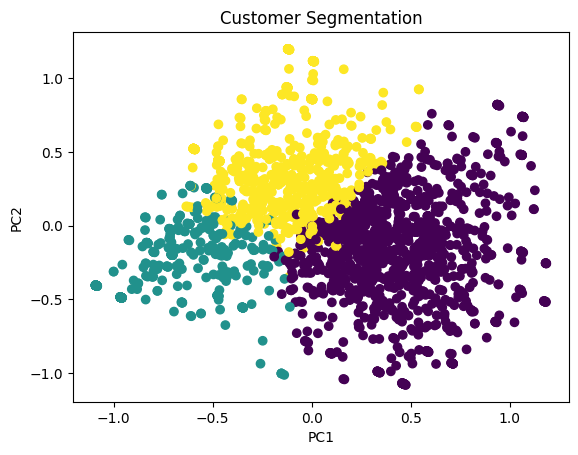

In [96]:
# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create a scatter plot
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels)

# Add labels and title
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Customer Segmentation')

# Show the plot
plt.show()

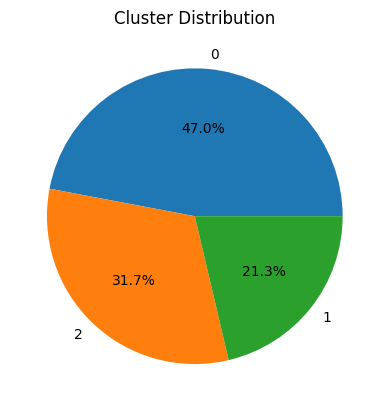

In [97]:
cluster_counts = df_scv['Cluster'].value_counts()

# Create a pie chart
plt.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%')

# Add a title to the chart
plt.title('Cluster Distribution')

# Display the chart
plt.show()

In [98]:
def pd_rec(cluster): # product recomend by cluster
  c = df[df['CUST_CODE'].isin(df_scv.loc[df_scv['Cluster']==cluster]['CUST_CODE'])]
  basket = c.groupby(['BASKET_ID', 'PROD_CODE_20'])['QUANTITY'].sum().unstack().reset_index().fillna(0).set_index('BASKET_ID')
  def encode_units(x):
      if x <= 0:
          return 0
      if x >= 1:
          return 1
  basket_encode = basket.applymap(encode_units)

  basket_filter = basket_encode[(basket_encode > 0).sum(axis=1)>=2]

  frequent_itemsets = apriori(basket_filter, min_support=0.05, use_colnames=True).sort_values('support', ascending=False).reset_index(drop=True)
  frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

  display(association_rules(frequent_itemsets, metric='lift', min_threshold=1).sort_values('lift', ascending=False).reset_index(drop=True))

In [99]:
pd_rec(0)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,"(DEP00008, DEP00046)","(DEP00067, DEP00011)",0.127082,0.191176,0.054262,0.426983,2.233458,0.029967,1.411518,0.632664
1,"(DEP00067, DEP00011)","(DEP00008, DEP00046)",0.191176,0.127082,0.054262,0.283832,2.233458,0.029967,1.218873,0.682798
2,"(DEP00021, DEP00008)","(DEP00053, DEP00011)",0.190069,0.129294,0.052664,0.277077,2.143003,0.028089,1.204425,0.658532
3,"(DEP00053, DEP00011)","(DEP00021, DEP00008)",0.129294,0.190069,0.052664,0.407319,2.143003,0.028089,1.366555,0.612566
4,"(DEP00067, DEP00008)","(DEP00049, DEP00011)",0.216678,0.115652,0.052541,0.242484,2.096678,0.027482,1.167432,0.667740
...,...,...,...,...,...,...,...,...,...,...
2941,(DEP00055),(DEP00019),0.188226,0.558778,0.108032,0.573947,1.027146,0.002855,1.035603,0.032557
2942,(DEP00005),(DEP00008),0.134210,0.488171,0.066552,0.495879,1.015791,0.001035,1.015291,0.017955
2943,(DEP00008),(DEP00005),0.488171,0.134210,0.066552,0.136329,1.015791,0.001035,1.002454,0.030372
2944,(DEP00054),(DEP00076),0.222516,0.257666,0.057396,0.257940,1.001062,0.000061,1.000369,0.001365


In [100]:
pd_rec(1)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(DEP00052),(DEP00054),0.348442,0.164306,0.072238,0.207317,1.261775,0.014987,1.054260,0.318414
1,(DEP00054),(DEP00052),0.164306,0.348442,0.072238,0.439655,1.261775,0.014987,1.162781,0.248255
2,(DEP00054),(DEP00055),0.164306,0.279037,0.053824,0.327586,1.173989,0.007977,1.072202,0.177342
3,(DEP00055),(DEP00054),0.279037,0.164306,0.053824,0.192893,1.173989,0.007977,1.035420,0.205563
4,(DEP00022),(DEP00052),0.171388,0.348442,0.067989,0.396694,1.138480,0.008270,1.079980,0.146795
5,(DEP00052),(DEP00022),0.348442,0.171388,0.067989,0.195122,1.138480,0.008270,1.029488,0.186685
6,(DEP00052),(DEP00055),0.348442,0.279037,0.109065,0.313008,1.121745,0.011837,1.049449,0.166573
7,(DEP00055),(DEP00052),0.279037,0.348442,0.109065,0.390863,1.121745,0.011837,1.069641,0.150537


In [101]:
pd_rec(2)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(DEP00011),"(DEP00019, DEP00008)",0.258468,0.119469,0.053403,0.206612,1.729415,0.022524,1.109836,0.568782
1,"(DEP00019, DEP00008)",(DEP00011),0.119469,0.258468,0.053403,0.446999,1.729415,0.022524,1.340923,0.478995
2,"(DEP00019, DEP00011)",(DEP00008),0.117028,0.278914,0.053403,0.456323,1.636074,0.020762,1.326315,0.440309
3,(DEP00008),"(DEP00019, DEP00011)",0.278914,0.117028,0.053403,0.191466,1.636074,0.020762,1.092066,0.539160
4,(DEP00020),(DEP00008),0.140067,0.278914,0.063015,0.449891,1.613012,0.023948,1.310806,0.441944
5,(DEP00008),(DEP00020),0.278914,0.140067,0.063015,0.225930,1.613012,0.023948,1.110924,0.527041
6,(DEP00008),(DEP00011),0.278914,0.258468,0.110619,0.396608,1.534457,0.038529,1.228940,0.483027
7,(DEP00011),(DEP00008),0.258468,0.278914,0.110619,0.427981,1.534457,0.038529,1.260599,0.469709
8,(DEP00011),(DEP00021),0.258468,0.153189,0.060726,0.234947,1.533707,0.021132,1.106866,0.469278
9,(DEP00021),(DEP00011),0.153189,0.258468,0.060726,0.396414,1.533707,0.021132,1.228545,0.410936
